# Beta calibration

## Introduction

Logistic calibration is designed to correct for a specific kind of distortion where classifiers tend to score on too narrow a scale. However, many classifiers including naive Bayes and Adaboost suffer from the opposite distortion where scores tend too much to the extremes. 

In this tutorial, we will motivate Beta calibration and our betacal Python package.

## Probability estimation with Naive Bayes

First, let's train a Naive Bayes model to estimate class probabilities for the well-known iris dataset. In this analysis, we focus on binary problems, so the original three classes are transformed into two classes like so: {0, {1,2}}. The dataset will be divided into a training set (50%), a test set (25%) and a calibration set (25%). The classifier will be trained on the training set and we'll estimate class probabilities for the test set.


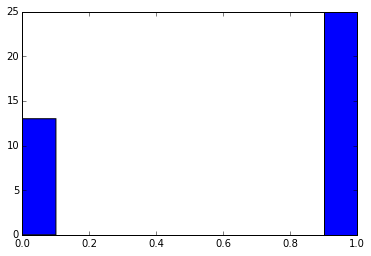

In [23]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

np.random.seed(42)
iris = load_iris()

iris.target[iris.target != 0] = 1

x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.5, stratify=iris.target)
x_cal, x_test, y_cal, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test)

nb = GaussianNB()
nb = nb.fit(x_train, y_train)
probas = nb.predict_proba(x_test)

plt.clf()
plt.hist(probas[:,1])
plt.show()

## Calibrating the scores

We can clearly see from the histogram that the probabilities produced by the model tend to assume extreme values. Therefore, it might be useful to apply calibration techniques to try and fix these distortions. Two calibration methods have been widely used in machine learning literature: logistic calibration and isotonic regression. The first one is a parametric method that assumes an underlying distribution of the scores composed of two Gaussians of equal variance, (one for the positives and another for the negatives). The second method is a non-parametric approach, therefore it doesn't make any assumption about the distribution of the scores, however, it needs a lot of data to produce a good model. Let's see the effect of applying these methods to the score of the previously trained classifier.

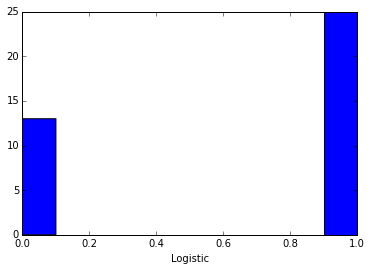

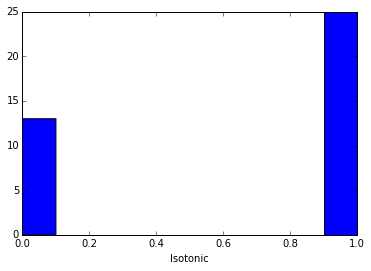

In [34]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

cal_probas = nb.predict_proba(x_cal)[:, 1]
lr = LogisticRegression(C=99999999999)
lr.fit(cal_probas.reshape(-1, 1), y_cal)

probas_lr = lr.predict_proba(probas[:,1].reshape(-1, 1))

plt.clf()
plt.hist(probas_lr[:,1])
plt.xlabel("Logistic")
plt.show()

iso = IsotonicRegression()
iso.fit(cal_probas, y_cal)

probas_iso = iso.predict(probas[:,1])

plt.clf()
plt.hist(probas_iso)
plt.xlabel("Isotonic")
plt.show()

## Reliability map

It seems that both calibration techniques were unable to improve the scores and correct the distortions. To understand what's happening, let's take a look at the reliability map .

[  6.83203768e-10   2.78668185e-09   3.95330790e-09   5.81752900e-09
   6.48035553e-09   1.08193550e-08   2.39666216e-08   2.86752345e-08
   5.41499842e-08   4.52710947e-07   1.04984999e-05   1.03908001e-04
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00]


C:\Users\tmfilho\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


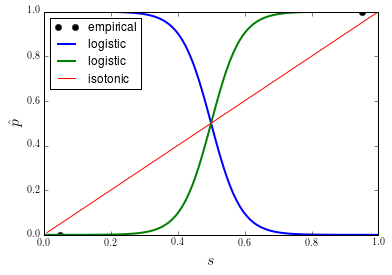

In [37]:
linspace = np.linspace(0, 1, 100)
pr = [linspace, lr.predict_proba(linspace.reshape(-1, 1)), iso.predict(linspace)]
idx = cal_probas.argsort()
scores = cal_probas[idx]
y_c_2 = y_cal[idx]
methods_text = ['uncalib', 'logistic', 'isotonic']
print scores
fig_map = plot_niculescu_mizil_map(pr, [scores, y_c_2, linspace], methods_text, alpha=0)


In [ ]:
from matplotlib import rc

def plot_niculescu_mizil_map(scores_set, prob, legend_set, alpha=1, **kwargs):
    rc('text', usetex=True)
    fig_reliability_map = plt.figure('reliability_map')
    fig_reliability_map.clf()
    ax_reliability_map = plt.subplot(111)
    ax = ax_reliability_map
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    ax.set_xlabel((r'$s$'), fontsize=16)
    ax.set_ylabel((r'$\hat{p}$'), fontsize=16)
    n_lines = len(legend_set)
    bins = np.linspace(0, 1, 11)
    hist_tot = np.histogram(prob[0], bins=bins)
    hist_pos = np.histogram(prob[0][prob[1] == 1], bins=bins)
    centers = (bins[:-1] + bins[1:])/2.0
    empirical_p = np.true_divide(hist_pos[0]+alpha, hist_tot[0]+2*alpha)
    ax.plot(centers, empirical_p, 'ko', label='empirical')

    for (scores, legend) in zip(scores_set, legend_set):
        if legend != 'uncalib':
            ax.plot(prob[2], scores, '-', label=legend, linewidth=n_lines,
                    **kwargs)
        n_lines -= 1
    ax.legend(loc='upper left')
    return fig_reliability_map